# Exponential Moving Average

**Overview**

The script consists of five functions. 

1. The download_data function fetches historical stock price data from Yahoo Finance.
2. The calculate_ema_signals function computes exponential moving averages and generates trade signals based on a crossover strategy.
3. The run_backtest simulates function simulates trading actions.
4. The plot_results function visualizes the crossover strategy.
5. The backtest_ema_strategy function takes in user inputs, executes the above functions, and presents the results.


**Further Information**

An exponential moving average (EMA) places a greater weight on and responds more to the most recent data points. This characteristic makes the EMA more sensitive to recent price changes when compared to a simple moving average (SMA), which gives equal weight to all data points in the period.  

A limitation of using an EMA strategy stems from the emphasis it places on more recent trading data. One can believe that either new data better reflects the current trend of the security, or, that it creates recency bias which causes false alarms. 

**Calculation**

The EMA is calculates using this formula:

\\[ 
\\text{EMA}_{t} = \left( \frac{{\text{Price}_{t} - \text{EMA}_{t-1}}}{{\text{span} + 1}} \right) + \text{EMA}_{t-1} 
\\]

Where:
- EMAt​ is the EMA at time t.
- Pricet​ is the price at time t.
- EMAt−1​ is the EMA at the previous time step.
- span is the span or period of the EMA.


**Pros**
- Responsive to recent price changes
- Smoothing of price data.
- Effective for trend identification.


**Cons**
- Lagging indicator.
    - Can only confirm a trend once it has already started.
    - Market efficiency. If the market, is efficient historical prices should tell us nothing about the future direction of an asset prices.
- Sensitive to period selection.
- Performs poorly in volatile markets.

## Disclaimer

1. This content is intended to be used and must be used for information and education purposes only. It is very important to do your own analysis before making any investment based on your own personal circumstances. You should take independent financial advice from a professional in connection with, or independently research and verify, any information presented below that you wish to rely upon, whether for the purpose of making an investment decision or otherwise.

2. The information provided below is strictly educational for the purpose of learning about securities, investments and market strategies. None of the content presented constitutes - or should be understood as constituting - a recommendation to enter in any securities transactions or to engage in any of the investment strategies presented.


## Investment Warnings

Please note the following important investment warnings.

1. The value of investments and the income derived from them can go down as well as up.
2. Investors may not get back the amount they invested. If the market moves against you, you may sustain a total loss greater than the amount you deposited into your account. You are responsible for all the risks and financial resources you use. You should not engage in trading unless you fully understand the nature of the transactions you are entering into and the extent of your exposure to loss. If you do not fully understand these risks you must seek independent advice from your financial advisor.
3. Past performance is not a guide to future performance.

## Notes on backtesting

1. Orders placed in the market are at-the-close orders.
2. Orders are made for whole shares only.
3. Orders have no transaction fees.
4. Orders have no market impact.
5. Orders have perfect execution.
6. Orders are made for the entire total of the cash balance/stock position.
8. Orders are not effected by halts.
9. Orders assume historical accuracy of the data set used. 

In [2]:
# Import packages
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
def download_data(stock_ticker, start_date, end_date):
    """
    Fetches historical stock price data from Yahoo Finance for a given ticker, creates a DataFrame, and normalizes the DataFrame's headers. 
    -
    Input:
    stock_ticker : str
    start_date : str
        (YYYY-MM-DD) format.
    end_date : str
        (YYYY-MM-DD) format.
    -
    Output:
    ema_df : Pandas DataFrame
    """
    data = yf.download(stock_ticker, start=start_date, end= end_date)

    if data.empty:
        raise ValueError(f"No data found for {stock_ticker}. Please check the ticker and date range.")
    
    ema_df = pd.DataFrame(data)

    ema_df.columns = ema_df.columns.str.lower().str.replace(' ', '_')

    return ema_df

In [13]:
def calculate_ema_signals(ema_df, short_ema, long_ema):
    """
    Takes the stock data DataFrame and computes an Exponential Moving Averages (EMA) then generates trade signals based on a crossover strategy.

    In the trade signal column, 1 is a buy signal, -1 is a sell signal.
    -
    Input:
    ema_df : Pandas DataFrame
    short_ema : int
    long_ema : int
    -
    Output:
    ema_df : Pandas DataFrame
    """
    # Create exponential moving average columns
    ema_df['short_ema'] = ema_df['close'].ewm(span=short_ema, adjust=False).mean()
    ema_df['long_ema'] = ema_df['close'].ewm(span=long_ema, adjust=False ).mean()

    # Create the 'trade_signal' column, assigns a 1 to the 'trade_signal' column if short_ema is greater than long_ema
    ema_df['trade_signal'] = (ema_df['short_ema'] > ema_df['long_ema']).astype(int)

    # # Create a new column 'action' which represents the action we should take based on changes in the 'trade_signal'
    # 0 to 1 is a buy signal, 1 to 0 is a sell signal
    # Fill NaNs with 0, diff() uses NaNs
    ema_df['action'] = ema_df['trade_signal'].diff().fillna(0)

    return ema_df

In [5]:
def run_backtest(ema_df, initial_cash_balance):
    """
    Takes the EMA DataFrame and simulates trading actions based on EMA (Exponential Moving Average) crossover strategy.
    -
    Input:
    ema_df : Pandas DataFrame
    initial_cash_balance : int
    -
    Output:
    ema_df : Pandas DataFrame
    """
    # Set backtesting parameters
    ema_df['cash_balance'] = initial_cash_balance
    ema_df['stock_position'] = 0
    ema_df['portfolio_value'] = initial_cash_balance
    running_cash_balance = initial_cash_balance
    stock_position = 0

    # Create backtesting loop
    for i in range(len(ema_df)):
        # If action is a buy signal
        if ema_df['action'].iloc[i] == 1:
            share_purchase = running_cash_balance // ema_df['close'].iloc[i]
            purchase_cost = share_purchase * ema_df['close'].iloc[i]
            running_cash_balance -= purchase_cost
            stock_position += share_purchase
        # If action is a sell signal
        elif ema_df['action'].iloc[i] == -1:
            running_cash_balance += stock_position * ema_df['close'].iloc[i]
            stock_position = 0
    
        ema_df.at[ema_df.index[i], 'cash_balance'] = running_cash_balance
        ema_df.at[ema_df.index[i], 'stock_position'] = stock_position
        ema_df.at[ema_df.index[i], 'portfolio_value'] = running_cash_balance + stock_position * ema_df['close'].iloc[i]

    return ema_df

In [16]:
def plot_results(ema_df, stock_ticker):
    """
    Visualizes the crossover strategy and the trade signals for a given stock.
    -
    Input:
    ema_df : Pandas DataFrame
    stock_ticker : str
    -
    Output:
    Two Charts
        - Stock Movement and ema Analysis
        - Portfolio Value Over Time
    """
    # Create subplots with two rows and one column
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

    # Plot the stock movement with short and long ema lines
    ax1.plot(ema_df.index, ema_df['close'], label='Stock Price', color='black')
    ax1.plot(ema_df.index, ema_df['short_ema'], label='Short EMA', color='orange')
    ax1.plot(ema_df.index, ema_df['long_ema'], label='Long EMA', color='purple')

    ax1.set_title(f'Stock Movement and EMA Analysis for {stock_ticker}')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)

    # Plot the portfolio value over time
    ax2.plot(ema_df.index, ema_df['portfolio_value'], label='Portfolio Value', color='black')

    # Annotate buy and sell signals with arrows
    buy_signals = ema_df[ema_df['action'] == 1]
    sell_signals = ema_df[ema_df['action'] == -1]
    ax2.scatter(buy_signals.index, buy_signals['portfolio_value'], marker='^', color='green', label='Buy Signal')
    ax2.scatter(sell_signals.index, sell_signals['portfolio_value'], marker='v', color='red', label='Sell Signal')

    ax2.set_title('Portfolio Value Over Time')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Portfolio Value')
    ax2.legend()
    ax2.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    plt.show()

In [17]:
def backtest_ema_strategy(stock_ticker, start_date, end_date, initial_cash, short_ema=20, long_ema=200):
    """
    Backtests EMA (Exponential Moving Average) crossover strategy. 
    -
    Input:
    stock_ticker : str
    start_date : str
    end_date : str
    initial_cash : int
    short_ema : int
    long_ema : int
    -
    Output:
    ema_portfolio_value : float
    """
    try:
        ema_df = download_data(stock_ticker, start_date, end_date)
        ema_df = calculate_ema_signals(ema_df, short_ema, long_ema)
        ema_df = run_backtest(ema_df, initial_cash)

        # Formatting
        print('-' * 68)
        print('\033[1mResults\033[0m')

        # Calculate the final portfolio value for a ema strategy
        ema_portfolio_value = ema_df["portfolio_value"].iloc[-1]
        print(f'EMA Final Portfolio Value: {ema_portfolio_value:.2f}')
        
        # Calculate the final portfolio value for a buy and hold strategy
        buy_hold_portfolio_value = initial_cash * (ema_df['close'].iloc[-1] / ema_df['close'].iloc[0])
        print(f'Buy and Hold Final Portfolio Value: {buy_hold_portfolio_value:.2f}')

        # Calculate percent difference between ema strategy and buy and hold strategy
        percent_difference = ((ema_portfolio_value - buy_hold_portfolio_value) / buy_hold_portfolio_value) * 100
        print(f'Percent Difference between EMA and Buy and Hold: {percent_difference:.2f}%')

        plot_results(ema_df, stock_ticker)
        
        return ema_portfolio_value
    
    except ValueError as e:
        print(e)

Enter a stock ticker symbol (e.g., AAPL):  CRSP
Enter a start date (YYYY-MM-DD):  2020-01-01
Enter a end date (YYYY-MM-DD):  2024-01-01
Enter an initial cash balance:  20000
Enter a short EMA day period (9, 12, or 20. The default is 20):  
Enter a long EMA period (26, 50 or 200. The default is 200):  


[*********************100%%**********************]  1 of 1 completed


--------------------------------------------------------------------
Results
EMA Final Portfolio Value: 17008.93
Buy and Hold Final Portfolio Value: 21105.87
Percent Difference between EMA and Buy and Hold: -19.41%


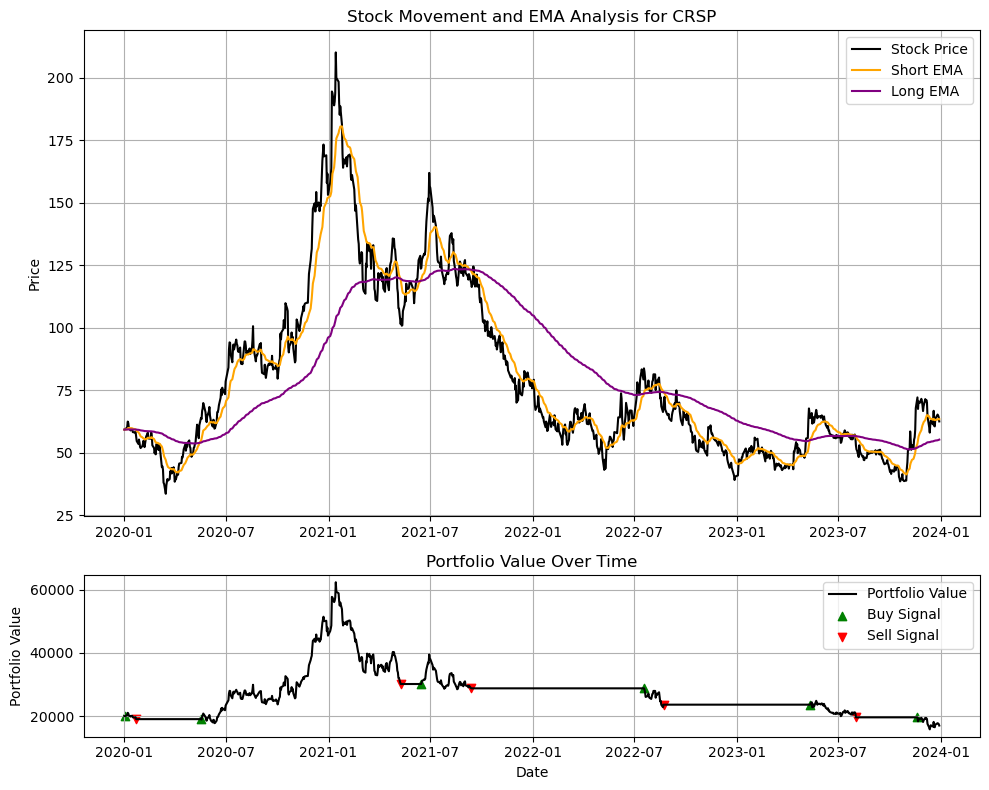

In [18]:
# Main execution
if __name__ == "__main__":
    stock_ticker = input("Enter a stock ticker symbol (e.g., AAPL): ")
    start_date = input("Enter a start date (YYYY-MM-DD): ")
    end_date = input("Enter a end date (YYYY-MM-DD): ")
    initial_cash = float(input("Enter an initial cash balance: "))

    short_ema = input("Enter a short EMA day period (9, 12, or 20. The default is 20): ")
    if short_ema == "":
        short_ema = 20
    else:
        short_ema = int(short_ema)

    long_ema = input("Enter a long EMA period (26, 50 or 200. The default is 200): ")
    if long_ema == "":
        long_ema = 200
    else:
        long_ema = int(long_ema)

    backtest_ema_strategy(stock_ticker, start_date, end_date, initial_cash, short_ema, long_ema)

In [19]:
ema_df = download_data('CRSP', '2020-01-01', '2024-01-01')
ema_df = calculate_ema_signals(ema_df, 20, 200)

ema_df

[*********************100%%**********************]  1 of 1 completed


,open,high,low,close,adj_close,volume,short_ema,long_ema,trade_signal,action
Date,,,,,,,,,,
2020-01-02,60.689999,60.700001,57.209999,59.320000,59.320000,1724700,59.320000,59.320000,0,0.0
2020-01-03,58.009998,60.279999,57.360001,59.439999,59.439999,1393900,59.331428,59.321194,1,1.0
2020-01-06,58.750000,60.279999,58.110001,59.950001,59.950001,1011500,59.390340,59.327451,1,0.0
2020-01-07,59.549999,61.139999,59.320000,60.349998,60.349998,875600,59.481736,59.337625,1,0.0
2020-01-08,60.040001,63.009998,59.770000,62.529999,62.529999,1510500,59.772047,59.369390,1,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-12-22,61.009998,64.779999,60.750000,63.669998,63.669998,2840800,63.158862,54.947203,1,0.0
2023-12-26,64.830002,65.889999,64.029999,65.330002,65.330002,1724200,63.365637,55.050514,1,0.0
2023-12-27,66.400002,67.160004,63.799999,64.959999,64.959999,1609400,63.517481,55.149116,1,0.0
